## Preparing the Data

As always, let's import all the required modules and set the random seeds for reproducability.

In [641]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time
import re
import unicodedata
from tqdm import tqdm

In [219]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We'll then create our tokenizers as before.

In [19]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [20]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

Our fields are the same as the previous notebook. The model expects data to be fed in with the batch dimension first, so we use `batch_first = True`. 

In [21]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

We then load the Multi30k dataset and build the vocabulary.

In [22]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:03<00:00, 336kB/s] 


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 138kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 107kB/s] 


In [23]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Finally, we define the device and the data iterator.

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [220]:
BATCH_SIZE = 1

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

In [594]:
SOS_token = 0
EOS_token = 1
PAD_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.char2index = {}
        self.char2count = {}
        self.index2char = {0: "<", 1: ">", 2: "+"}
        self.n_chars = 2  # Count SOS and EOS

    def addWord(self, word):
        for character in list(word):
            self.addCharacter(character)

    def addCharacter(self, character):
        if character not in self.char2index:
            self.char2index[character] = self.n_chars
            self.char2count[character] = 1
            self.index2char[self.n_chars] = character
            self.n_chars += 1
        else:
            self.char2count[character] += 1


def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )



def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('../data/zulu/zulu.clean.train.conll', encoding='utf-8').\
        read().strip().split('\n')
    data = []
    for line in lines:
        line = line.split(" | ")
        ortho = removeTags(line[3])
        data.append(line[0] + "\t" + ortho)
    # Split every line into pairs and normalize
    #print(data)
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in data]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    #s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s



MAX_LENGTH = 40

def filterPair(p):
    return p


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def removeTags(segments):
    ortho = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", segments)
    ortho = ortho.replace("[]","-")[:-1]

    return ortho


def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addWord(pair[0])
        output_lang.addWord(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_chars)
    print(output_lang.name, output_lang.n_chars)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('zulu', 'train', False)
print(input_lang.index2char)
print(output_lang.char2index)

print(random.choice(pairs))

Reading lines...
Read 17778 sentence pairs
Trimmed to 17778 sentence pairs
Counting words...
Counted words:
zulu 43
train 46
{0: '<', 1: '>', 2: 'n', 3: 'g', 4: 'e', 5: 'z', 6: 'i', 7: 'k', 8: 'o', 9: 'y', 10: 'm', 11: 'u', 12: 'w', 13: 't', 14: 'h', 15: 'l', 16: 'a', 17: 'b', 18: 'p', 19: 'd', 20: 'q', 21: 's', 22: 'x', 23: 'r', 24: 'c', 25: 'v', 26: 'f', 27: 'j', 28: "'", 29: '2', 30: '9', 31: '0', 32: '4', 33: '7', 34: '3', 35: '1', 36: '8', 37: '5', 38: '6', 39: '.', 40: '"', 41: ',', 42: '%'}
{'n': 2, 'g': 3, 'a': 4, '-': 5, 'i': 6, 'z': 7, 'k': 8, 'o': 9, 'y': 10, 'l': 11, 'm': 12, 'u': 13, 'w': 14, 't': 15, 'h': 16, 'b': 17, 'e': 18, 'p': 19, 'd': 20, 'q': 21, 's': 22, 'x': 23, 'r': 24, 'c': 25, 'v': 26, 'f': 27, 'j': 28, '(': 29, ')': 30, "'": 31, '2': 32, '9': 33, '0': 34, '4': 35, '7': 36, '3': 37, '1': 38, '8': 39, '5': 40, '6': 41, '.': 42, '"': 43, ',': 44, '%': 45}
['ukukhokhela', 'u-ku-khokh-el-a']


In [595]:
def indexesFromWord(lang, word):
    return [lang.char2index[char] for char in list(word)]


def tensorFromWord(lang, word):
    indexes = indexesFromWord(lang, word)
    # while(len(indexes)!=MAX_LENGTH-1):
    #     indexes.append(PAD_token)
    indexes.append(EOS_token)
    indexes.insert(0, SOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromWord(input_lang, pair[0])
    target_tensor = tensorFromWord(output_lang, pair[1])
    return (input_tensor, target_tensor)

training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(1)]
#print(training_pairs[0])print(training_pairs[0][1].shape)
print(training_pairs[0][0].shape, training_pairs[0][1].shape)
for c in training_pairs[0][1]:
    print(output_lang.index2char[c.item()], end='')
    
print("")
for c in training_pairs[0][0]:
    print(input_lang.index2char[c.item()], end='')



torch.Size([11, 1]) torch.Size([14, 1])
<kwa-a-kamuva>
<kwakamuva>

In [596]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [597]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [598]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [599]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [600]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [601]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [602]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
        
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
#         print("SRC MASK: ", src_mask)
#         print("TRG MASK: ", trg_mask)
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [603]:
print(input_lang.n_chars)

43


In [604]:
INPUT_DIM = input_lang.n_chars
OUTPUT_DIM = output_lang.n_chars
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

Then, use them to define our whole sequence-to-sequence encapsulating model.

In [605]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, PAD_token, PAD_token, device).to(device)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(43, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
       

We can check the number of parameters, noticing it is significantly less than the 37M for the convolutional sequence-to-sequence model.

In [606]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,039,470 trainable parameters


The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

In [637]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(initialize_weights);

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

Next, we define our loss function, making sure to ignore losses calculated over `<pad>` tokens.

In [638]:

lines = open('../Data/Zulu/zulu.clean.dev.conll', encoding='utf-8').\
read().strip().split('\n')
devData = []
correct = 0
for line in lines:
    line = line.lower()
    line = line.split(" | ")
    ortho = removeTags(line[3])
    #print(ortho)
    devData.append(line[0] + "\t" + ortho)
    
print(devData)

['ngezinkonzo\tnga-i-zin-konzo', 'kwabanamandla\tkwa-a-ba-namandla', 'yokuqinisekisa\tya-u-ku-qin-is-ek-is-a', 'izinkonzo\ti-zin-khonzo', 'ezizosiza\tezi-zo-siz-a', 'lwezinkonzo\tlwa-i-zin-khonzo', 'amasevisi\ta-ma-sevisi', 'oluqondene\to-lu-qond-an-ile', 'ehambisana\te-hamb-is-an-a', 'izigaba\ti-zi-gaba', 'nemigomo\tna-i-mi-gomo', 'esikhonjiswe\tesi-khomb-is-w-e', 'okwenzekayo\toku-enz-ek-a-yo', 'isipedi\ti-si-pedi', 'ngezinkonzo\tnga-i-zin-khonzo', 'elithi\teli-th-i', 'yolwazi\ti-yo-lu-az-i', 'nemikhakha\tna-i-mi-khakha', 'lwezinkonzo\tlwa-i-zin-khonzo', 'ngokubonelela\tnga-u-ku-bon-elel-a', 'kuzoseshwa\tku-zo-sesh-w-a', 'ngokukhetha\tnga-u-ku-kheth-a', 'ngamagama\tnga-a-ma-gama', 'iwebsite\ti-website', 'njalo\tnjalo', 'esixhumanisana\tesi-xhum-an-is-an-a', 'lwayo\tlwa-yo', 'nengqikithi\tna-i-n-ngqikithi', 'amafomu\ta-ma-fomu', 'udinga\tu-ding-a', 'sincoma\tsi-ncom-a', 'ukuyethula\tu-ku-yi-ethul-a', 'kuleyo\tku-leyo', 'ngenkinobho\tnga-i-n-nkinobho', 'kwinkinobho\tkwi-i-n-nkinobho', 

In [639]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [647]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

criterion = nn.CrossEntropyLoss(ignore_index = PAD_token)

def train(model, iterator, optimizer, criterion, clip, iterations):
    
    model.train()
    
    epoch_loss = 0
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(iterations)]
    #for i, batch in enumerate(iterator):
    for i, pair in enumerate(training_pairs):  
        #print(pair)
        training_pair = training_pairs[i - 1]
        input_tensor  = training_pair[0].view(1, -1)
        target_tensor = training_pair[1].view(1, -1)
        print(input_tensor)
        print(target_tensor)
#         print(target_tensor.shape)
        #src = batch.src
        #trg = batch.trg
        
        #print("org: ",src.shape)
        #print(trg.shape)
        optimizer.zero_grad()
        
        output, _ = model(input_tensor, target_tensor[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        target_tensor = target_tensor[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, target_tensor)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        #print(loss.item())
        epoch_loss += loss.item()
        
    return epoch_loss  / len(iterator)

In [627]:
def evaluate(model, iterator, criterion, n):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
        
        for line in devData[0:n]:
            
            source, target = line.split("\t")
            #print(source, target)
            
            source = tensorFromWord(input_lang, source).view(1, -1)
            target = tensorFromWord(output_lang, target).view(1, -1)
            #print(source.shape, target.shape)
            output, _ = model(source, target[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            target = target[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, target)
            #print(loss.item())

            epoch_loss += loss.item()
    return epoch_loss  / n

In [648]:
N_EPOCHS = 3
CLIP = 1
iterations = 10000
best_valid_loss = float('inf')
model = Seq2Seq(enc, dec, PAD_token, PAD_token, device).to(device)



for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, iterations)
    valid_loss = evaluate(model, valid_iterator, criterion, iterations)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | ')
    print(f'\t Val. Loss: {valid_loss:.3f} | ')

tensor([[ 0,  7,  8,  7, 14,  4, 13, 14,  8,  1]])
tensor([[ 0,  8, 14,  4,  5, 13,  5, 11, 13,  5,  8, 16, 18, 15, 16,  9,  1]])
tensor([[ 0,  2,  8,  7,  8,  2,  3, 16,  1]])
tensor([[ 0,  2,  4,  5, 13,  5,  8, 13,  5,  9,  2,  3,  5,  4,  1]])
tensor([[0, 6, 9, 4, 1]])
tensor([[ 0,  6,  5, 10,  5, 18,  1]])
tensor([[ 0,  6, 17, 16, 27,  4, 13,  6,  1]])
tensor([[ 0,  6,  5, 17,  4, 28, 18, 15,  6,  1]])
tensor([[ 0,  7, 12,  4,  5,  4,  2, 13,  4,  2,  3,  8,  1]])
tensor([[ 0,  8, 14,  5,  6,  5,  7, 18,  2, 15, 18,  2,  3,  9,  1]])
tensor([[ 0, 16, 17, 16, 18, 14,  6, 15, 16,  1]])
tensor([[ 0,  4, 17,  4,  5, 19, 16,  6, 11,  5,  4,  1]])
tensor([[ 0,  6,  5,  6, 13, 21, 14, 16, 15,  8,  1]])
tensor([[ 0,  6,  5,  7,  6,  5, 15, 22, 16,  4, 11,  9,  1]])
tensor([[ 0,  6,  5,  6,  2, 14, 15, 16,  2,  3, 16,  2,  8,  1]])
tensor([[ 0,  6,  5,  7,  6,  2,  5, 16, 11,  4,  2,  3,  4,  2,  9,  1]])
tensor([[ 0, 17, 16, 13, 14, 16, 13, 14,  4, 15, 16,  1]])
tensor([[ 0, 17,  4,  5, 1

KeyboardInterrupt: 

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [644]:
model.load_state_dict(torch.load('model.pt'))

test_loss = evaluate(model, test_iterator, criterion, 2500)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.382 | Test PPL:  10.825 |


## Inference

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [645]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        

    tokens = [token for token in sentence]

    print("t ", tokens)   
    src_indexes = [input_lang.char2index[token] for token in tokens]
    src_indexes.insert(0, SOS_token)
    src_indexes.append(EOS_token)
    print(src_indexes)
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    print(src_tensor.shape)
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [SOS_token]
    print(trg_indexes)
    for i in range(max_len):
        print(trg_indexes)
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)
        if pred_token == EOS_token:
            break
    
    trg_tokens = [output_lang.index2char[i] for i in trg_indexes]
    
    return trg_tokens, attention


In [646]:
randomLength = 200
randomLine = devData[random.randint(0,randomLength)]
src, trg = randomLine.split('\t')
print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, input_lang, output_lang, model, device)

print(f'predicted trg = {translation}')

src = iwebsite
trg = i-website
t  ['i', 'w', 'e', 'b', 's', 'i', 't', 'e']
[0, 6, 12, 4, 17, 21, 6, 13, 4, 1]
torch.Size([1, 10])
[0]
[0]
[0, 9]
[0, 9, 9]
[0, 9, 9, 9]
[0, 9, 9, 9, 9]
[0, 9, 9, 9, 9, 9]
[0, 9, 9, 9, 9, 9, 9]
[0, 9, 9, 9, 9, 9, 9, 9]
[0, 9, 9, 9, 9, 9, 9, 9, 9]
[0, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[0, 9, 9, 9, 9,

In [621]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(20,15))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

We can see the attention from each head below. Each is certainly different, but it's difficult (perhaps impossible) to reason about what head has actually learned to pay attention to. Some heads pay full attention to "eine" when translating "a", some don't at all, and some do a little. They all seem to follow the similar "downward staircase" pattern and the attention when outputting the last two tokens is equally spread over the final two tokens in the input sentence.

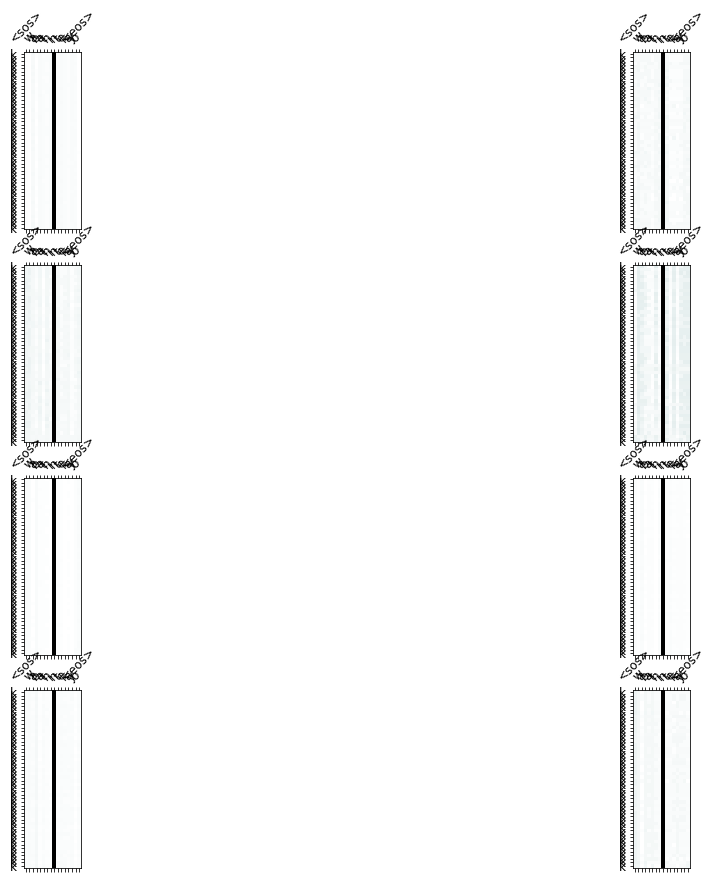

In [535]:
display_attention(src, translation, attention)

Next, let's get an example the model has not been trained on from the validation set.

In [ ]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


The model translates it by switching *is running* to just *running*, but it is an acceptable swap.

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'running', 'after', 'the', 'black', 'dog', '.', '<eos>']


Again, some heads pay full attention to "ein" whilst some pay no attention to it. Again, most of the heads seem to spread their attention over both the period and `<eos>` tokens in the source sentence when outputting the period and `<eos>` sentence in the predicted target sentence, though some seem to pay attention to tokens from near the start of the sentence.

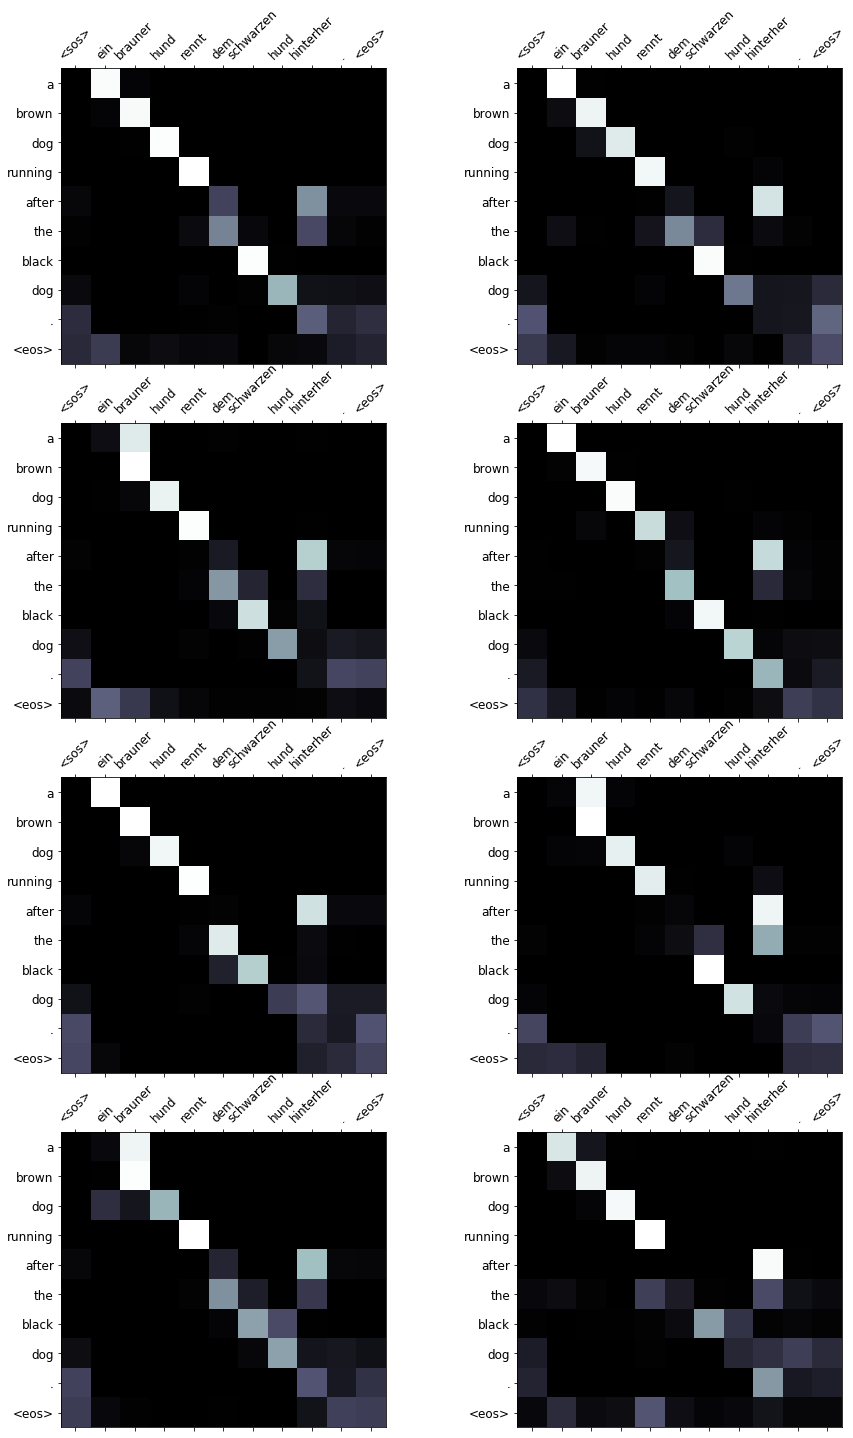

In [ ]:
display_attention(src, translation, attention)

Finally, we'll look at an example from the test data.

In [ ]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


A decent translation with *young* being omitted.

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'her', 'son', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<eos>']


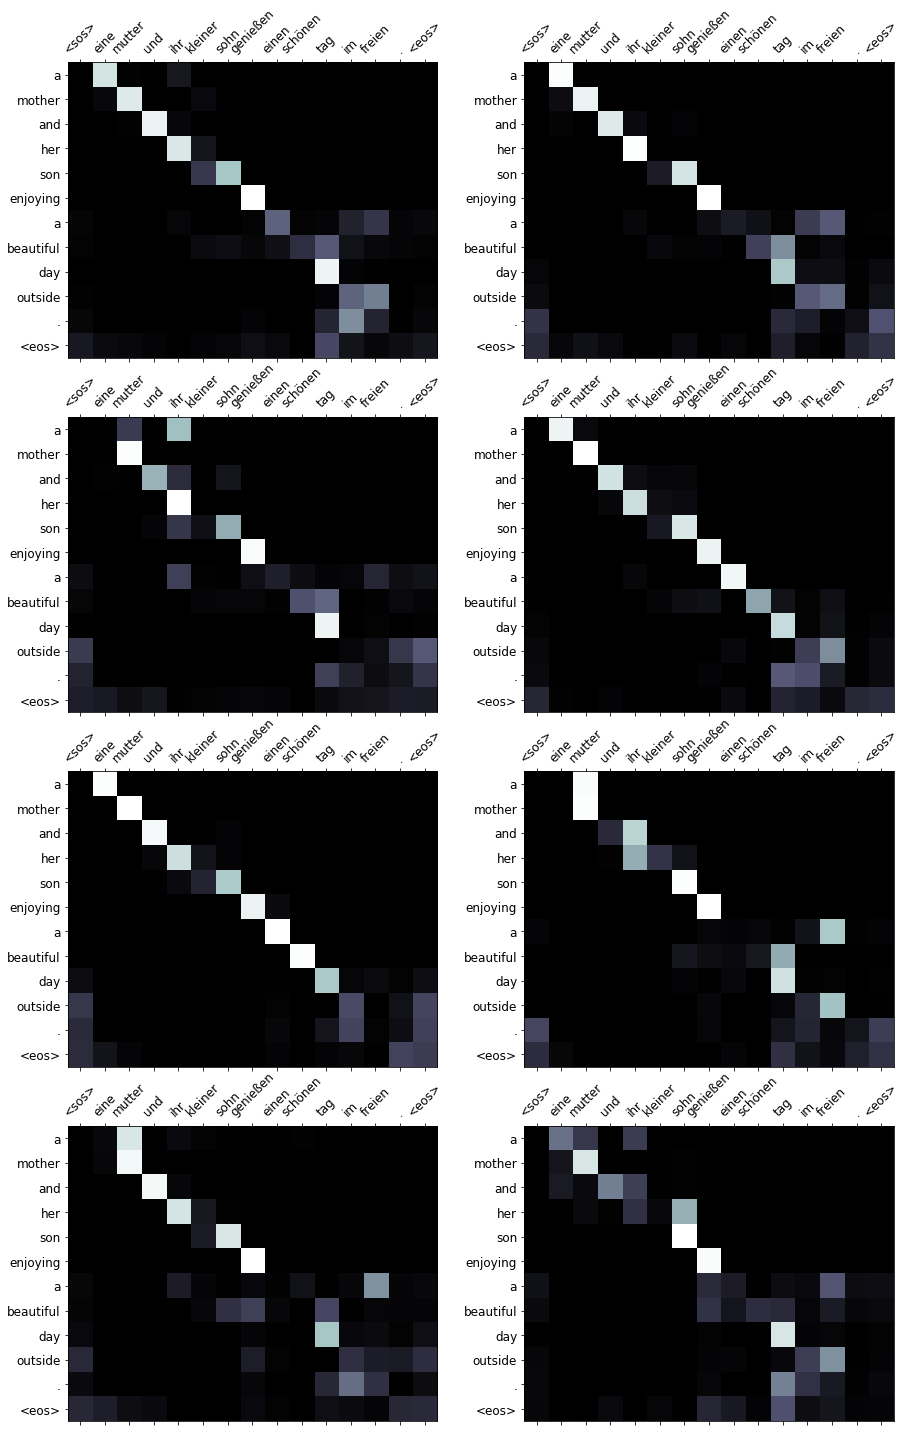

In [ ]:
display_attention(src, translation, attention)

## BLEU

Finally we calculate the BLEU score for the Transformer.

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

We get a BLEU score of 35.08, which beats the 33.3 of the convolutional sequence-to-sequence model and 28.2 of the attention based RNN model. All this whilst having the least amount of parameters and the fastest training time!

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.08


Congratulations for finishing these tutorials! I hope you've found them useful.

If you find any mistakes or want to ask any questions about any of the code or explanations used, feel free to submit a GitHub issue and I will try to correct it ASAP. 